In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import geopandas as gpd
from IPython.display import Image
from bokeh.plotting import  figure, output_notebook, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool, CustomJS
from bokeh.models.widgets import Select
from bokeh.transform import factor_cmap
from bokeh.layouts import column as bokeh_column
from bokeh.models import TabPanel
from bokeh.models import Legend
from country_name import *



In [ ]:
# Load and preprocess data
df = pd.read_csv('data/clean_combined.csv')

In [23]:
#Intro image
print("Forest Fire")

Image(url= "image/fire.jpg", width=900, height=700)

Forest Fire


In [3]:
# Filter and reshape data for 'World'
df_world = df[df['Entity'] == 'World']
df_world = df_world.melt(id_vars=['Entity', 'Code', 'Year'], 
                         value_vars=['Cropland', 'Pasture', 'Permanent ice', 'Semi-natural land', 'Urban', 'Villages', 'Wild barren land', 'Wild woodlands'], 
                         var_name='Land_type', 
                         value_name='Area_Aggregated_Categories')

In [4]:
# Drop rows with NaN values
df_world = df_world.dropna(subset=['Area_Aggregated_Categories'])


df_world['Year'] = df_world['Year'].astype(int)

# Group and pivot data
df_world = df_world[df_world['Year'] >= 200]
df_world = df_world.groupby(['Year', 'Land_type'])['Area_Aggregated_Categories'].sum().reset_index()
df_world = df_world.pivot(index='Year', columns='Land_type', values='Area_Aggregated_Categories').fillna(0)

# Convert to percentages
df_world = df_world.divide(df_world.sum(axis=1), axis=0) * 100

In [5]:
# Plot chart 1
# Define a custom color palette using hex color codes
custom_palette = {
    'Cropland': '#FF8D85',  # Dark orange
    'Pasture': '#B22222',  # Firebrick
    'Wild barren land': '#FFD700',  # Gold
    'Permanent ice': '#4073FF',  # Light sky blue
    'Wild woodlands': '#064E40',  # Forest green
    'Semi-natural land':'#6ACCBC',        
    'Urban': '#808080', # Gray
    'Villages': '#804000'  # Gray
}

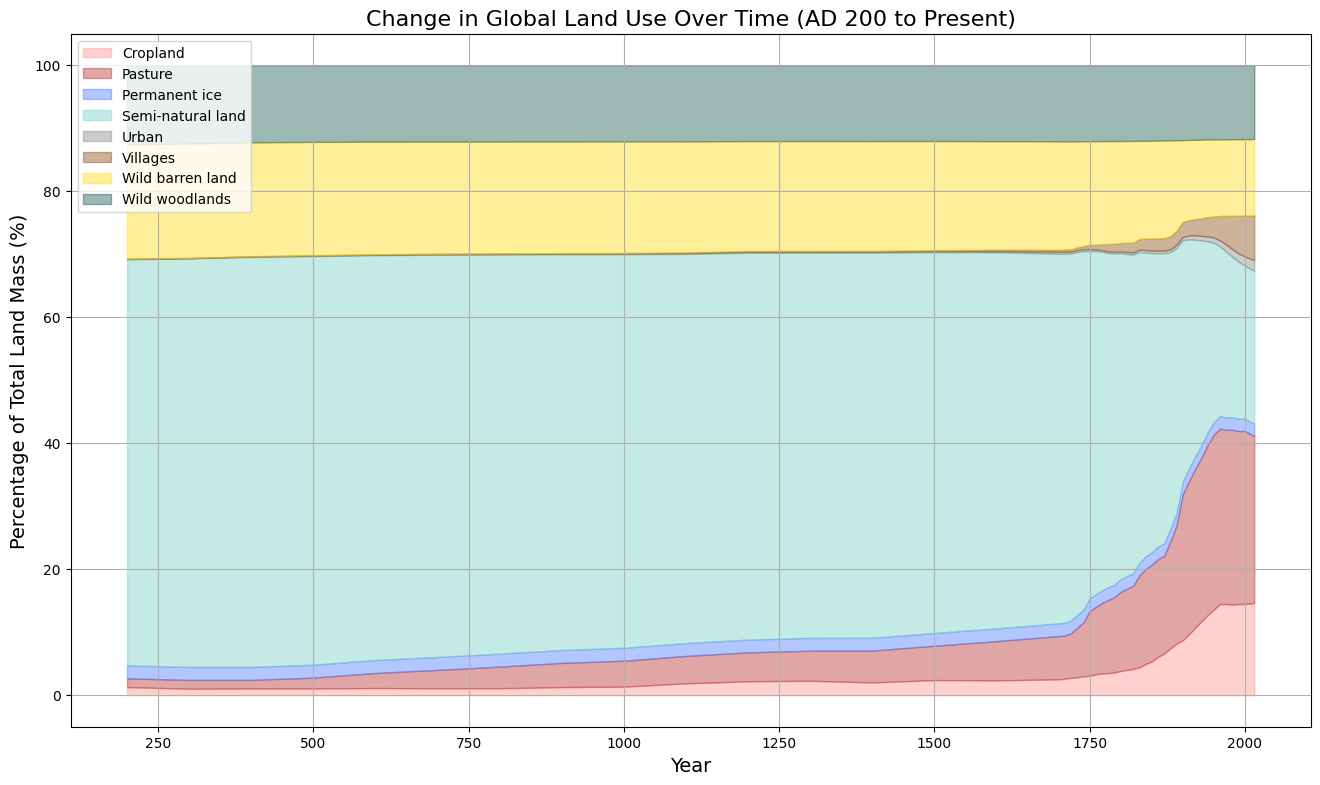

In [6]:
# Create a new figure
plt.figure(figsize=(16, 9))
#plt.suptitle('Chart 1', fontsize=20, y=1.03)


# Initialize a variable to store the cumulative sum
cumulative_sum = np.zeros_like(df_world.iloc[:, 0])

# Plot a stacked area chart
for column in df_world.columns:
    plt.fill_between(df_world.index, cumulative_sum, cumulative_sum + df_world[column], color=custom_palette.get(column, 'lightgray'), alpha=0.4)
    cumulative_sum += df_world[column]
    
# Set labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percentage of Total Land Mass (%)', fontsize=14)
plt.title('Change in Global Land Use Over Time (AD 200 to Present)', fontsize=16)

plt.grid(True)
plt.legend(df_world.columns, loc='upper left')

plt.show()

In [ ]:

print("earth habitable land area")
Image(url= "image/earth.jpeg", width=800, height=900)



earth


In [7]:
# Load photo
agriculture_data = pd.read_csv('data/habitable-land-needed.csv')
world_map = gpd.read_file('image/ne_10m_admin_0_countries.shp')

In [8]:

world_map['SOVEREIGNT'] = world_map['SOVEREIGNT'].replace(country_name_corrections)

# Remove leading/trailing spaces
world_map['SOVEREIGNT'] = world_map['SOVEREIGNT'].str.strip()
agriculture_data['Entity'] = agriculture_data['Entity'].str.strip()

# Separate 'World' data
world_data = agriculture_data[agriculture_data['Entity'] == 'World']
country_data = agriculture_data[agriculture_data['Entity'] != 'World']

In [9]:

# Add missing countries
missing_countries_df = pd.DataFrame(missing_countries, columns=['Entity'])
missing_countries_df['HALF Index (habitable land area) (Alexander et al. (2016))'] = np.nan
agriculture_data = pd.concat([agriculture_data, missing_countries_df], ignore_index=True)


In [10]:
# Merge dataframes
merged_data = world_map.merge(agriculture_data, how='left', left_on='SOVEREIGNT', right_on='Entity')

# Include 'World' data
world = pd.concat([merged_data, world_data])

# Calculate world average
world_average = world_data['HALF Index (habitable land area) (Alexander et al. (2016))'].values[0]


<Figure size 640x480 with 0 Axes>

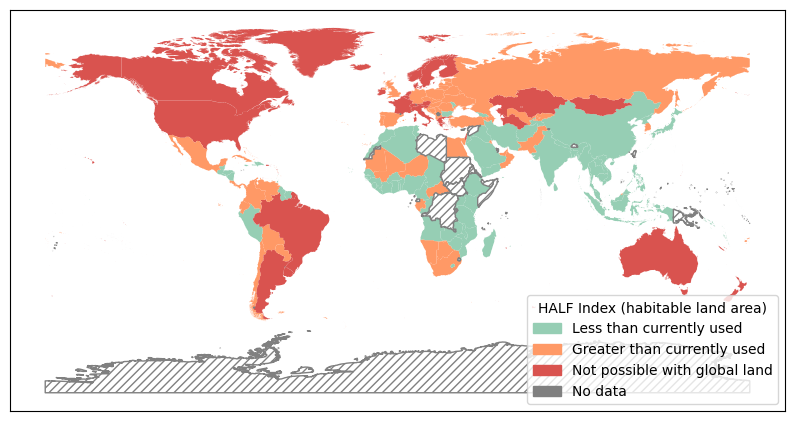

In [11]:
# Add the title and the description
plt.suptitle("Share of global habitable land needed if everyone had the diet of...", fontsize=14, fontweight='bold')


# Assign color categories
world['color_category'] = np.where(
    world['HALF Index (habitable land area) (Alexander et al. (2016))'].isnull(), 'no_data',
    np.where(world['HALF Index (habitable land area) (Alexander et al. (2016))'] < world_average, 'blue',
    np.where(world['HALF Index (habitable land area) (Alexander et al. (2016))'] <= 99, 'yellow', 'red')))

# Map color categories to actual colors
color_mappings = {'blue': '#96ceb4', 'yellow': '#ff9966', 'red': '#d9534f', 'no_data': '#7f7f7f'}
world['color'] = world['color_category'].map(color_mappings)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
world[world['color_category'] != 'no_data'].geometry.plot(facecolor=world[world['color_category'] != 'no_data']['color'], ax=ax)
world[world['color_category'] == 'no_data'].geometry.plot(facecolor='none', edgecolor='grey', hatch='////', ax=ax)

# Legend
legend_labels = {
    '#96ceb4': 'Less than currently used',
    '#ff9966': 'Greater than currently used',
    '#d9534f': 'Not possible with global land',
    'grey': 'No data'
}
legend_handles = [mpatches.Patch(color=color, label=label, hatch='////' if color == 'grey' else None) for color, label in legend_labels.items()]
plt.legend(legend_handles, legend_labels.values(), title='HALF Index (habitable land area)', loc='lower right')

# Remove x and y axis marks
ax.set_xticks([])
ax.set_yticks([])



plt.show()

In [25]:

print("water usage")
Image(url= "image/water.JPG", width=800, height=700)


water usage


In [12]:
# Ensure output_notebook() is called in the same cell
output_notebook()

Loading BokehJS ...

In [13]:
# Create 'Proportion Allocated to Animal Feed' and 'Proportion Allocated to Other Uses' columns
df['Total Cereal Allocation'] = df[['Cereals allocated to other uses', 'Cereals allocated to animal feed', 'Cereals allocated to human food']].sum(axis=1)
df['Proportion Allocated to Human Food'] = df['Cereals allocated to human food'] / df['Total Cereal Allocation']
df['Proportion Allocated to Animal Feed'] = df['Cereals allocated to animal feed'] / df['Total Cereal Allocation']
df['Proportion Allocated to Other Uses'] = df['Cereals allocated to other uses'] / df['Total Cereal Allocation']

# Convert proportions to percentages
for column in ['Proportion Allocated to Human Food', 'Proportion Allocated to Animal Feed', 'Proportion Allocated to Other Uses']:
    df[column] *= 100
    

In [14]:
# Filter the DataFrame
df_large_population = df[~df['Entity'].isin(small_population_countries)]

# Get column names
column_names = df_large_population.columns.tolist()

# Remove rows with missing values in relevant columns
df_remove_na = df_large_population.dropna(subset=['Cereals allocated to other uses', 
                             'Cereals allocated to animal feed', 
                             'Cereals allocated to human food', 'Year', 'Entity'])

df_clean = df_remove_na.drop(['Cropland',
 'Pasture',
 'Permanent ice',
 'Semi-natural land',
 'Urban',
 'Villages',
 'Wild barren land',
 'Wild woodlands'], axis=1)

In [15]:
# Convert 'Year' to int
df_clean['Year'] = df_clean['Year'].astype(int)


# Create a list of unique countries
countries = df_clean['Entity'].unique()



# Create a ColumnDataSource for each country
sources = {country: ColumnDataSource(df_clean[df_clean['Entity'] == country]) for country in countries}


In [16]:
# Create the initial figure
p = figure(width=800, height=250, x_axis_type="linear", title=countries[0])
p.xaxis.axis_label = 'Year'
p.yaxis.axis_label = 'Cereal Allocation (%)'

# Define the stack order and colors
stacks = ['Proportion Allocated to Human Food', 'Proportion Allocated to Animal Feed', 'Proportion Allocated to Other Uses']
# Define a custom color palette
colors = ["#FFB6C1", "#9370DB", "#ADD8E6"]
legend_labels = ['Human Food', 'Animal Feed', 'Other Uses']


# Add varea_stack to the plot
renderers = p.varea_stack(stacks, x='Year', color=colors, alpha=0.6, source=sources[countries[0]])

# Create a Legend
legend = Legend(items=[(label, [r]) for label, r in zip(legend_labels, renderers)], location="top_left", click_policy="hide")

# Add the legend to the plot
p.add_layout(legend)


hover = HoverTool(
    tooltips=[
        ("Year", "@Year"),
        ("Human Food (%)", "@{Proportion Allocated to Human Food}"),
        ("Animal Feed (%)", "@{Proportion Allocated to Animal Feed}"),
        ("Other Uses (%)", "@{Proportion Allocated to Other Uses}")
    ]
)
p.add_tools(hover)

# Create a Select widget for country selection
country_select = Select(value=countries[0], options=list(countries))

# Define a CustomJS callback for the Select widget
callback = CustomJS(args=dict(sources=sources, plot=p), code="""
    var country = cb_obj.value;
    plot.title.text = country;
    plot.renderers[0].data_source.data = sources[country].data;
    plot.change.emit();
""")
country_select.js_on_change('value', callback)

# Show the plot and the Select widget
show(bokeh_column(country_select, p))

In [ ]:
print(" Europe less than one-third of cereal production is used for human consumption, and in the US only 10 percent is.")
print("global land use")
Image(url= "image/Land-use-of-different-diets.png", width=800, height=700)


global land use


In [27]:

print("mammal_earth")
Image(url= "image/mammal_earth.png", width=800, height=700)

mammal_earth
